# Introduction to Multiple Regression

## Brief Recap of Linear Regression

Linear Regression is a statistical method that models the relationship between a dependent variable (target) and one independent variable (predictor) by fitting a linear equation to the observed data. The linear equation is of the form:

**$$ Y = a + bX $$**

Where:

- **Y** is the predicted value of the dependent variable (what we want to find out).
- **X** is the independent variable (the input).
- **a** is the intercept of the line (where the line crosses the Y-axis).
- **b** is the slope of the line (how much Y changes with each unit change in X).


## Multiple Regression

Multiple Regression extends Linear Regression by modeling the relationship between a dependent variable and multiple independent variables. It helps to understand the impact of several factors on the target variable simultaneously. The equation for Multiple Regression is:

**$$ Y = a + b_1X_1 + b_2X_2 + \ldots + b_nX_n $$**

Where:
- **Y** is the dependent variable (the variable we are trying to predict).
- **a** is the intercept (the expected mean value of Y when all X variables are 0).
- **b_1, b_2, ..., b_n** are the coefficients (slopes) for each independent variable.
- **X_1, X_2, ..., X_n** are the independent variables (predictors).


![Alt Text](multiple_linear_regression.png)

## Differences between Simple and Multiple Regression

| Aspect | Simple Regression | Multiple Regression |
|--------|-------------------|---------------------|
| Number of Independent Variables | One | Multiple |
| Model Complexity | Simple | More Complex |
| Equation | $Y = a + bX$ | $Y = a + b_1X_1 + b_2X_2 + \ldots + b_nX_n$ |

# Building a Multiple Regression Model for House Prices

In this notebook, we will build a Multiple Regression Model to predict house prices based on various factors like size (in square feet), number of rooms, and location using a dataset of house prices in Bangalore.

## Step 1: Importing Libraries
First, we need to import the necessary libraries.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Loading the Dataset

In [11]:
# Load the dataset
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df.shape

(13320, 9)

In [6]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


## Step 3: Data Cleaning and Preparation
We need to clean the data and prepare it for modeling. This includes handling missing values, converting categorical variables, and selecting relevant features.

In [12]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [13]:
# Drop unnecessary columns
df = df.drop(['area_type', 'society', 'balcony'], axis=1)
df.head()

,availability,location,size,total_sqft,bath,price
0,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Ready To Move,Uttarahalli,3 BHK,1440,2.0,62.00
3,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Ready To Move,Kothanur,2 BHK,1200,2.0,51.00


In [14]:
# Drop rows with missing values
df = df.dropna()
df.shape

(13246, 6)

In [16]:
# Remove any 'total_sqft' entries that are not numeric (range values, etc.)
def convert_sqft_to_num(x):
    try:
        float(x)
        return float(x)
    except:
        if '-' in x:
            temp = x.split('-')
            return (float(temp[0]) + float(temp[1])) / 2
        else:
            return None
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df = df.dropna()
df.shape

(13200, 6)

In [17]:
# Convert the size column to number of bedrooms\n",
def extract_bhk(x):
    if 'BHK' in x or 'Bedroom' in x:
        return int(x.split(' ')[0])
    elif 'Bedroom' in x:
        return int(x.split(' ')[0])
    else:
        return None
df['bhk'] = df['size'].apply(extract_bhk)
# Drop rows where BHK could not be determined
df = df.dropna(subset=['bhk'])
df.head()

,availability,location,size,total_sqft,bath,price,bhk
0,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2.0
1,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4.0
2,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,62.00,3.0
3,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3.0
4,Ready To Move,Kothanur,2 BHK,1200.0,2.0,51.00,2.0


In [18]:
df.location = df.location.apply(lambda x: x.strip())
location_count = df['location'].value_counts(ascending=False)
location_count

location
Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [19]:
location_count_less_than_30 = location_count[location_count<=30]
location_count_less_than_30

location
Doddathoguru                 30
Chikkalasandra               30
Ananth Nagar                 30
Kumaraswami Layout           30
Dodda Nekkundi               29
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1191, dtype: int64

In [20]:
df.location = df.location.apply(lambda x: 'other' if x in location_count_less_than_30 else x)
len(df.location.unique())

97

In [22]:
df.head()

,availability,location,size,total_sqft,bath,price,bhk
0,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2.0
1,Ready To Move,other,4 Bedroom,2600.0,5.0,120.00,4.0
2,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,62.00,3.0
3,Ready To Move,other,3 BHK,1521.0,3.0,95.00,3.0
4,Ready To Move,Kothanur,2 BHK,1200.0,2.0,51.00,2.0


In [24]:
# Encode 'location' using LabelEncoder
le = LabelEncoder()
df['location_encoded'] = le.fit_transform(df['location'])
df['availability_encoded'] = le.fit_transform(df['availability'])
df.head()

,availability,location,size,total_sqft,bath,price,bhk,location_encoded,availability_encoded
0,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2.0,25,40
1,Ready To Move,other,4 Bedroom,2600.0,5.0,120.00,4.0,96,79
2,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,62.00,3.0,87,79
3,Ready To Move,other,3 BHK,1521.0,3.0,95.00,3.0,96,79
4,Ready To Move,Kothanur,2 BHK,1200.0,2.0,51.00,2.0,60,79


## Step 4: Visualize the Data

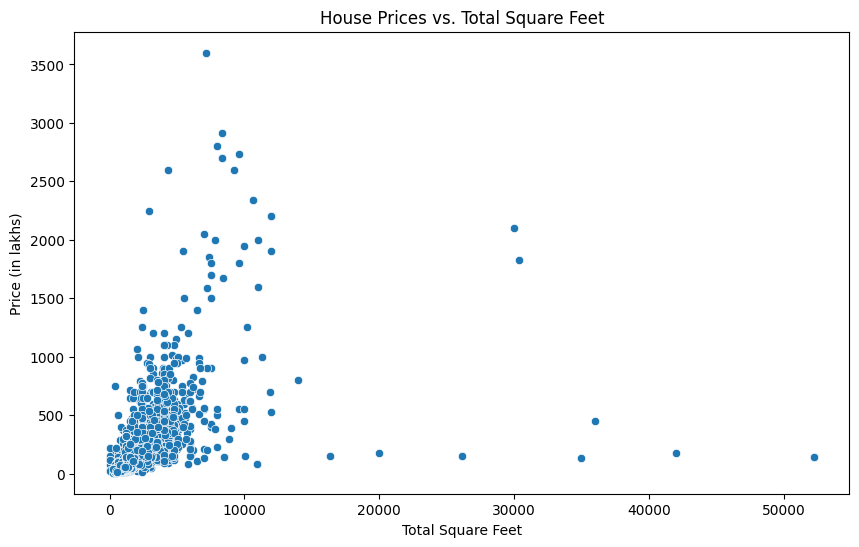

In [27]:
# Scatter plot of house prices vs. total square feet
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_sqft', y='price', data=df)
plt.title('House Prices vs. Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('Price (in lakhs)')
plt.show()

In [28]:
df = df[df['total_sqft'] <= 8000]
df = df[df['price'] <= 1500]
df.shape

(13138, 9)

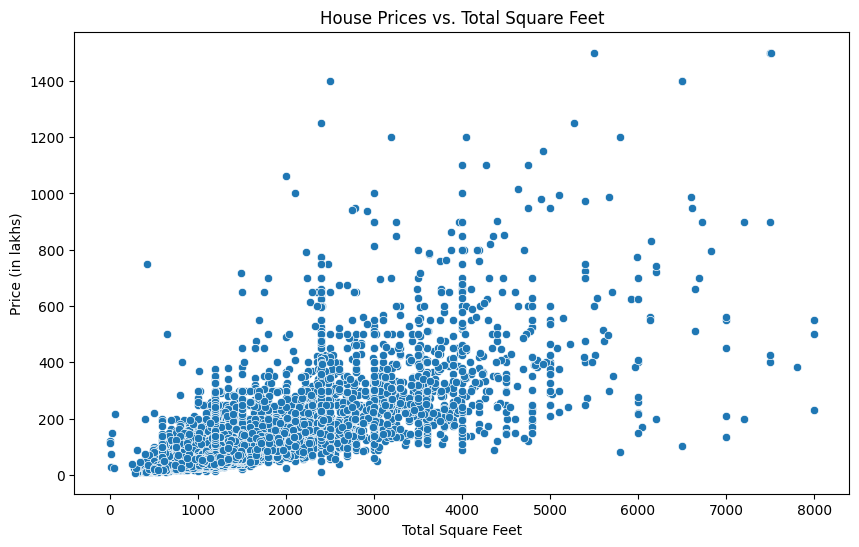

In [29]:
# Scatter plot of house prices vs. total square feet
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_sqft', y='price', data=df)
plt.title('House Prices vs. Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('Price (in lakhs)')
plt.show()

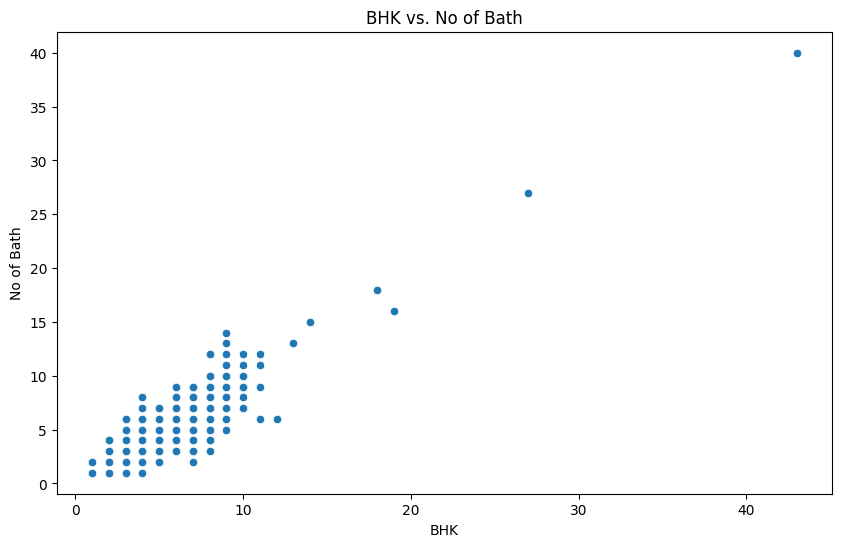

In [30]:
# Scatter plot of no of rooms vs. no of Bathroom
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bhk', y='bath', data=df)
plt.title('BHK vs. No of Bath')
plt.xlabel('BHK')
plt.ylabel('No of Bath')
plt.show()

In [31]:
df = df[df['bath'] <= 10]
df.shape

(13121, 9)

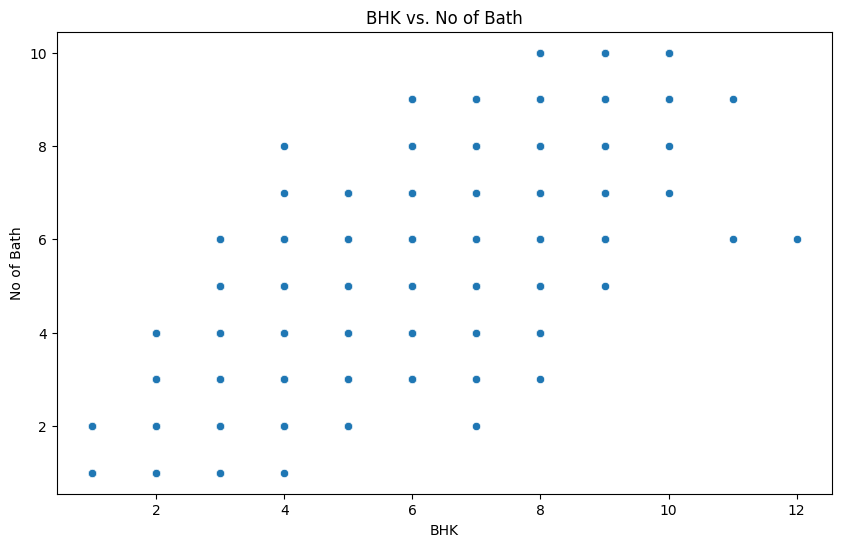

In [32]:
# Scatter plot of no of rooms vs. no of Bathroom
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bhk', y='bath', data=df)
plt.title('BHK vs. No of Bath')
plt.xlabel('BHK')
plt.ylabel('No of Bath')
plt.show()

## Step 5: Splitting the Data
We will split the data into training and testing sets.

In [33]:
# Define the features (X) and target (y)
X = df[['total_sqft', 'bhk', 'location_encoded']]
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 6: Building the Multiple Regression Model
Next, we will create a Multiple Regression model using the training data.

In [34]:
# Creating and training the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [35]:
# Getting the model parameters
coefficients = model.coef_
intercept = model.intercept_

# Printing the coefficients and intercept
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Coefficients: [ 0.09285631 13.48114398  0.18442268]
Intercept: -84.27587822526394


## Step 7: Making Predictions
We will now use the model to make predictions on the test set.

In [36]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# Printing the predicted values
print(f"Predicted values: {y_pred[:5]}")
print(f"Actual values: {y_test.values[:5]}")

Predicted values: [ 94.58533002  73.58798492  85.29969935 123.18894226 122.32229582]
Actual values: [170.  70.  55. 100. 150.]


## Step 8: Evaluating the Model
To evaluate the model, we will use metrics like Mean Squared Error (MSE) and R-squared (R²).

In [37]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 6739.572947879999
R-squared: 0.5427380576752228


## Step 9: Visualizing the Results
Finally, we will visualize the actual vs. predicted house prices.

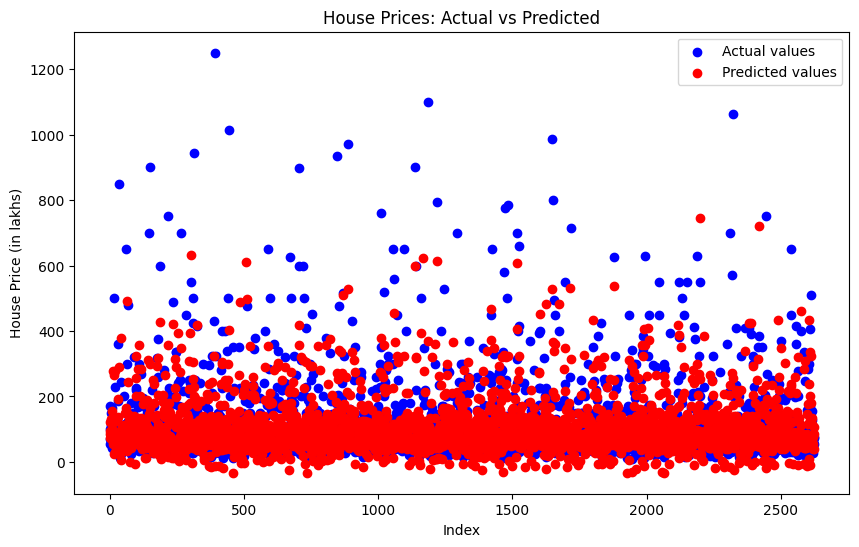

In [38]:
# Visualizing the results
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Predicted values')
plt.title('House Prices: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('House Price (in lakhs)')
plt.legend()
plt.show()

## Step 10: Testing the Model

In [39]:
def predict_house_price(total_sqft, bhk, location):
    # Filter data for the given location and number of BHK
    df_filtered = df[(df['location'] == location) & (df['bhk'] == bhk)]
    
    # Train a simple linear regression model (example purposes only)
    X = df_filtered[['total_sqft']].values.reshape(-1, 1)
    y = df_filtered['price'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the price for the given total_sqft
    predicted_price = model.predict([[total_sqft]])
    
    return predicted_price[0]

In [42]:
total_sqft = 1000
bhk = 2
location = 'Uttarahalli'

predicted_price = predict_house_price(total_sqft, bhk, location)
print(predicted_price)

40.72277838107381


## Conclusion
In this notebook, we built a Multiple Regression model to predict house prices based on size, number of rooms, and location. We went through data preparation, model building, making predictions, and evaluating the model. We also visualized the actual vs. predicted house prices to understand the model's performance.